In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectFromModel, RFE, mutual_info_classif, f_classif, SelectKBest
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')

In [17]:
# Charger le fichier des combats UFC
ufc_data = pd.read_csv('ufc_data.csv')

# Ne conserver que les colonnes qui nous intéressent
ufc_fights = ufc_data[['r_fighter', 'b_fighter', 'winner']].copy()

# Afficher un aperçu
print(f"Nombre de combats: {len(ufc_fights)}")
ufc_fights.head()

Nombre de combats: 7973


,r_fighter,b_fighter,winner
0,Josh Emmett,Lerone Murphy,Blue
1,Pat Sabatini,Joanderson Brito,Red
2,Cortavious Romious,ChangHo Lee,Blue
3,Brad Tavares,Gerald Meerschaert,Red
4,Ode Osbourne,Luis Gurule,Red


In [18]:
def parse_fighter_stats(file_path):
    """
    Parse le fichier de statistiques des combattants et retourne un dictionnaire.
    """
    fighter_stats = {}
    current_fighter = None
    current_stats = {}
    
    # Liste des champs qui devraient être des nombres
    numeric_fields = ['wins', 'losses', 'height', 'weight', 'reach', 'age', 
                      'SLpM', 'sig_str_acc', 'SApM', 'str_def', 
                      'td_avg', 'td_acc', 'td_def', 'sub_avg']
    
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if not line:
                continue
                
            if line.startswith('name:'):
                # Si nous avons déjà un combattant en cours, l'ajouter au dictionnaire
                if current_fighter:
                    fighter_stats[current_fighter] = current_stats
                
                # Commencer un nouveau combattant
                current_fighter = line.split('name:')[1].strip()
                current_stats = {}
            else:
                # Ajouter la statistique au combattant en cours
                try:
                    key, value = line.split(':')
                    key = key.strip()
                    value = value.strip()
                    
                    # Convertir les valeurs en nombres si possible
                    if key in numeric_fields:
                        try:
                            value = float(value)
                        except ValueError:
                            # Si la conversion échoue, mettre une valeur par défaut
                            print(f"Avertissement: Impossible de convertir {key}:{value} en nombre pour {current_fighter}")
                            value = 0.0
                    
                    current_stats[key] = value
                except ValueError:
                    print(f"Avertissement: Ligne mal formatée ignorée: {line}")
        
        # Ajouter le dernier combattant
        if current_fighter:
            fighter_stats[current_fighter] = current_stats
    
    return fighter_stats

# Charger les statistiques des combattants
fighter_stats = parse_fighter_stats('fighters_stats.txt')

# Afficher un exemple
print(f"Nombre de combattants: {len(fighter_stats)}")
if 'Josh Emmett' in fighter_stats:
    print("\nStatistiques pour Josh Emmett:")
    print(fighter_stats['Josh Emmett'])

Avertissement: Impossible de convertir reach:None en nombre pour Jesus Pinedo
Avertissement: Impossible de convertir reach:None en nombre pour Michel Batista
Avertissement: Impossible de convertir reach:None en nombre pour Jesus Pinedo
Avertissement: Impossible de convertir reach:None en nombre pour Kalindra Faria
Avertissement: Impossible de convertir reach:None en nombre pour Jay Cucciniello
Avertissement: Impossible de convertir reach:None en nombre pour Kalindra Faria
Avertissement: Impossible de convertir reach:None en nombre pour Christian Colombo
Avertissement: Impossible de convertir reach:None en nombre pour Kalindra Faria
Avertissement: Impossible de convertir reach:None en nombre pour Pearl Gonzalez
Avertissement: Impossible de convertir reach:None en nombre pour Chan-Mi Jeon
Avertissement: Impossible de convertir reach:None en nombre pour Azunna Anyanwu
Avertissement: Impossible de convertir reach:None en nombre pour Abdul-Kerim Edilov
Avertissement: Impossible de convertir

In [19]:
def create_features(fights_df, stats_dict):
    """
    Crée des features améliorés pour chaque combat basés sur les statistiques des combattants.
    """
    data = []
    
    # Liste des statistiques numériques que nous utiliserons
    numeric_stats = ['wins', 'losses', 'height', 'weight', 'reach', 'age', 
                    'SLpM', 'sig_str_acc', 'SApM', 'str_def', 
                    'td_avg', 'td_acc', 'td_def', 'sub_avg']
    
    for _, row in fights_df.iterrows():
        r_fighter = row['r_fighter']
        b_fighter = row['b_fighter']
        winner = row['winner']  # 'Red' ou 'Blue'
        
        # Vérifier si les deux combattants sont dans notre dictionnaire
        if r_fighter not in stats_dict or b_fighter not in stats_dict:
            continue
        
        r_stats = stats_dict[r_fighter]
        b_stats = stats_dict[b_fighter]
        
        # Création des features
        features = {
            'r_fighter': r_fighter,
            'b_fighter': b_fighter
        }
        
        # ----- DESCRIPTEURS DE BASE -----
        
        # Ajouter les statistiques absolues
        for stat in numeric_stats:
            if stat in r_stats and stat in b_stats:
                # S'assurer que les valeurs sont des nombres
                r_value = r_stats[stat]
                b_value = b_stats[stat]
                
                # Convertir en float si ce n'est pas déjà le cas
                if not isinstance(r_value, (int, float)):
                    try:
                        r_value = float(r_value)
                    except ValueError:
                        r_value = 0.0
                
                if not isinstance(b_value, (int, float)):
                    try:
                        b_value = float(b_value)
                    except ValueError:
                        b_value = 0.0
                
                features[f'r_{stat}'] = r_value
                features[f'b_{stat}'] = b_value
                
                # Ajouter la différence (rouge - bleu)
                features[f'diff_{stat}'] = r_value - b_value
                
                # Ajouter le ratio (rouge / bleu) si b_value n'est pas nul
                if b_value != 0:
                    features[f'ratio_{stat}'] = r_value / b_value
                else:
                    features[f'ratio_{stat}'] = np.nan
        
        # ----- DESCRIPTEURS AVANCÉS -----
        
        # 1. Win ratio et expérience
        r_wins = get_float_value(r_stats, 'wins', 0)
        r_losses = get_float_value(r_stats, 'losses', 0)
        b_wins = get_float_value(b_stats, 'wins', 0)
        b_losses = get_float_value(b_stats, 'losses', 0)
        
        # Nombre total de combats (expérience)
        features['r_total_fights'] = r_wins + r_losses
        features['b_total_fights'] = b_wins + b_losses
        features['diff_total_fights'] = features['r_total_fights'] - features['b_total_fights']
        
        # Win ratio
        if r_wins + r_losses > 0:
            features['r_win_ratio'] = r_wins / (r_wins + r_losses)
        else:
            features['r_win_ratio'] = 0
        
        if b_wins + b_losses > 0:
            features['b_win_ratio'] = b_wins / (b_wins + b_losses)
        else:
            features['b_win_ratio'] = 0
            
        features['diff_win_ratio'] = features['r_win_ratio'] - features['b_win_ratio']
        
        # 2. Striking efficiency et statistiques offensives/défensives
        r_slpm = get_float_value(r_stats, 'SLpM', 0)
        r_sapm = get_float_value(r_stats, 'SApM', 0)
        b_slpm = get_float_value(b_stats, 'SLpM', 0)
        b_sapm = get_float_value(b_stats, 'SApM', 0)
        
        # Efficacité de frappe
        features['r_striking_efficiency'] = r_slpm - r_sapm
        features['b_striking_efficiency'] = b_slpm - b_sapm
        features['diff_striking_efficiency'] = features['r_striking_efficiency'] - features['b_striking_efficiency']
        
        # Ratio frappe/défense
        if r_sapm > 0:
            features['r_strike_defense_ratio'] = r_slpm / r_sapm
        else:
            features['r_strike_defense_ratio'] = r_slpm if r_slpm > 0 else 1.0
            
        if b_sapm > 0:
            features['b_strike_defense_ratio'] = b_slpm / b_sapm
        else:
            features['b_strike_defense_ratio'] = b_slpm if b_slpm > 0 else 1.0
            
        features['diff_strike_defense_ratio'] = features['r_strike_defense_ratio'] - features['b_strike_defense_ratio']
        
        # 3. Différences physiques 
        r_height = get_float_value(r_stats, 'height', 0)
        r_weight = get_float_value(r_stats, 'weight', 0)
        r_reach = get_float_value(r_stats, 'reach', 0)
        b_height = get_float_value(b_stats, 'height', 0)
        b_weight = get_float_value(b_stats, 'weight', 0)
        b_reach = get_float_value(b_stats, 'reach', 0)
        
        # Rapport taille/poids
        if r_weight > 0:
            features['r_height_weight_ratio'] = r_height / r_weight
        else:
            features['r_height_weight_ratio'] = 0
            
        if b_weight > 0:
            features['b_height_weight_ratio'] = b_height / b_weight
        else:
            features['b_height_weight_ratio'] = 0
            
        features['diff_height_weight_ratio'] = features['r_height_weight_ratio'] - features['b_height_weight_ratio']
        
        # Avantage d'allonge normalisé par la taille
        if r_height > 0:
            features['r_reach_height_ratio'] = r_reach / r_height
        else:
            features['r_reach_height_ratio'] = 0
            
        if b_height > 0:
            features['b_reach_height_ratio'] = b_reach / b_height
        else:
            features['b_reach_height_ratio'] = 0
            
        features['diff_reach_height_ratio'] = features['r_reach_height_ratio'] - features['b_reach_height_ratio']
        
        # 4. Indicateurs de style de combat
        r_td_avg = get_float_value(r_stats, 'td_avg', 0)
        r_sub_avg = get_float_value(r_stats, 'sub_avg', 0)
        r_str_def = get_float_value(r_stats, 'str_def', 0)
        r_td_def = get_float_value(r_stats, 'td_def', 0)
        b_td_avg = get_float_value(b_stats, 'td_avg', 0)
        b_sub_avg = get_float_value(b_stats, 'sub_avg', 0)
        b_str_def = get_float_value(b_stats, 'str_def', 0)
        b_td_def = get_float_value(b_stats, 'td_def', 0)
        
        # Spécialiste de striking vs grappling
        if r_td_avg > 0:
            features['r_striking_grappling_ratio'] = r_slpm / r_td_avg
        else:
            features['r_striking_grappling_ratio'] = r_slpm if r_slpm > 0 else 0
            
        if b_td_avg > 0:
            features['b_striking_grappling_ratio'] = b_slpm / b_td_avg
        else:
            features['b_striking_grappling_ratio'] = b_slpm if b_slpm > 0 else 0
            
        # Offensive vs défensive (plus le ratio est élevé, plus le combattant est offensif)
        features['r_offensive_rating'] = r_slpm * r_td_avg * (1 + r_sub_avg)
        features['b_offensive_rating'] = b_slpm * b_td_avg * (1 + b_sub_avg)
        features['diff_offensive_rating'] = features['r_offensive_rating'] - features['b_offensive_rating']
        
        features['r_defensive_rating'] = r_str_def * r_td_def
        features['b_defensive_rating'] = b_str_def * b_td_def
        features['diff_defensive_rating'] = features['r_defensive_rating'] - features['b_defensive_rating']
        
        # 5. Variables composites
        # Performance globale = win_ratio * offensive_rating * defensive_rating
        features['r_overall_performance'] = features['r_win_ratio'] * features['r_offensive_rating'] * features['r_defensive_rating']
        features['b_overall_performance'] = features['b_win_ratio'] * features['b_offensive_rating'] * features['b_defensive_rating']
        features['diff_overall_performance'] = features['r_overall_performance'] - features['b_overall_performance']
        
        # Avantage physique combiné (taille, poids, allonge)
        features['r_physical_advantage'] = features['r_reach_height_ratio'] * features['r_height_weight_ratio']
        features['b_physical_advantage'] = features['b_reach_height_ratio'] * features['b_height_weight_ratio']
        features['diff_physical_advantage'] = features['r_physical_advantage'] - features['b_physical_advantage']
        
        # 6. Style matching
        if 'stance' in r_stats and 'stance' in b_stats:
            features['same_stance'] = 1 if r_stats['stance'] == b_stats['stance'] else 0
            features['r_stance'] = r_stats['stance']
            features['b_stance'] = b_stats['stance']
        
        # 7. Target: 1 si Rouge gagne, 0 si Bleu gagne
        features['winner'] = 1 if winner == 'Red' else 0
        
        data.append(features)
    
    return pd.DataFrame(data)

def get_float_value(stats_dict, key, default=0.0):
    """
    Récupère une valeur du dictionnaire et la convertit en float.
    """
    if key not in stats_dict:
        return default
        
    value = stats_dict[key]
    
    if isinstance(value, (int, float)):
        return float(value)
    
    try:
        return float(value)
    except (ValueError, TypeError):
        return default

# Créer les features avec les descripteurs améliorés
features_df = create_features(ufc_fights, fighter_stats)

# Convertir les stances en variables catégorielles
stance_columns = ['r_stance', 'b_stance']
for col in stance_columns:
    if col in features_df.columns:
        dummies = pd.get_dummies(features_df[col], prefix=col)
        features_df = pd.concat([features_df, dummies], axis=1)
        features_df.drop(col, axis=1, inplace=True)

# Afficher les dimensions
print(f"Nombre de combats avec features: {len(features_df)}")
print(f"Nombre de features: {features_df.shape[1] - 3}")  # -3 pour r_fighter, b_fighter, winner
features_df.head()

Nombre de combats avec features: 7951
Nombre de features: 101


,r_fighter,b_fighter,r_wins,b_wins,diff_wins,ratio_wins,r_losses,b_losses,diff_losses,ratio_losses,...,r_stance_Orthodox,r_stance_Sideways,r_stance_Southpaw,r_stance_Switch,b_stance_,b_stance_Open Stance,b_stance_Orthodox,b_stance_Sideways,b_stance_Southpaw,b_stance_Switch
0,Josh Emmett,Lerone Murphy,19.0,16.0,3.0,1.187500,5.0,0.0,5.0,NaN,...,True,False,False,False,False,False,True,False,False,False
1,Pat Sabatini,Joanderson Brito,20.0,17.0,3.0,1.176471,5.0,5.0,0.0,1.000000,...,True,False,False,False,False,False,True,False,False,False
2,Cortavious Romious,ChangHo Lee,9.0,11.0,-2.0,0.818182,4.0,1.0,3.0,4.000000,...,False,False,True,False,False,False,True,False,False,False
3,Brad Tavares,Gerald Meerschaert,21.0,37.0,-16.0,0.567568,11.0,19.0,-8.0,0.578947,...,True,False,False,False,False,False,False,False,True,False
4,Ode Osbourne,Luis Gurule,13.0,10.0,3.0,1.300000,8.0,1.0,7.0,8.000000,...,False,False,True,False,False,False,True,False,False,False


In [20]:
# Séparer les features et la cible
X = features_df.drop(['r_fighter', 'b_fighter', 'winner'], axis=1)
y = features_df['winner']

# Afficher les statistiques descriptives pour repérer les anomalies
print("Statistiques descriptives des features:")
print(X.describe().T)

# Vérifier les valeurs manquantes
print("\nNombre de valeurs manquantes par colonne:")
print(X.isna().sum())

# Remplacer les valeurs manquantes et infinies
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(0, inplace=True)

# Normaliser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Diviser en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(f"Dimensions de X_train: {X_train.shape}")
print(f"Dimensions de X_test: {X_test.shape}")

Statistiques descriptives des features:
                           count       mean        std         min        25%  \
r_wins                    7951.0  19.246887   9.331655    0.000000  13.000000   
b_wins                    7951.0  17.265250   9.073907    0.000000  11.000000   
diff_wins                 7951.0   1.981638  11.440936 -241.000000  -4.000000   
ratio_wins                7903.0   1.386445   1.931778    0.000000   0.789474   
r_losses                  7951.0   8.011697   4.655448    0.000000   5.000000   
...                          ...        ...        ...         ...        ...   
diff_overall_performance  7951.0   0.391584   4.021549  -36.733657  -0.945973   
r_physical_advantage      7951.0   2.376875   0.648638    0.000000   2.239917   
b_physical_advantage      7951.0   2.241527   0.857309    0.000000   2.157866   
diff_physical_advantage   7951.0   0.135348   0.757197   -3.311350  -0.097393   
same_stance               7951.0   0.606842   0.488482    0.000000   

Sélection de variables avec RandomForest...

Top 20 features les plus importantes selon RandomForest:
                      Feature  Importance
61             diff_win_ratio    0.054818
60                b_win_ratio    0.023641
64   diff_striking_efficiency    0.022219
3                  ratio_wins    0.021697
21                      b_age    0.021136
67  diff_strike_defense_ratio    0.020557
84   diff_overall_performance    0.019348
72       b_reach_height_ratio    0.018342
86       b_physical_advantage    0.017444
25                     b_SLpM    0.017245
66     b_strike_defense_ratio    0.016774
2                   diff_wins    0.016622
23                  ratio_age    0.015850
0                      r_wins    0.015212
59                r_win_ratio    0.015183
27                 ratio_SLpM    0.014392
80         b_defensive_rating    0.014105
73    diff_reach_height_ratio    0.014019
26                  diff_SLpM    0.013971
81      diff_defensive_rating    0.013130


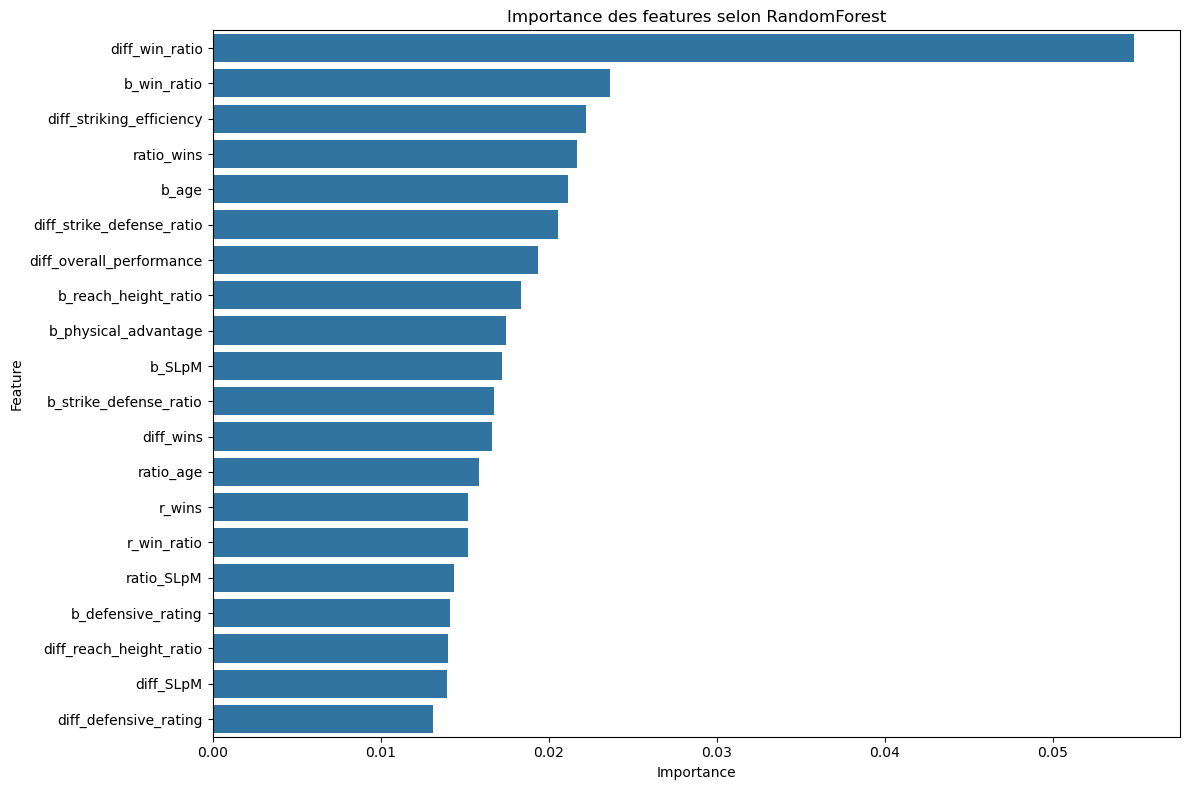


Sélection de variables avec ANOVA (f_classif)...

Top 20 features selon ANOVA (f_classif):
                     Feature       Score        p-value
61            diff_win_ratio  737.570947  9.087341e-154
64  diff_striking_efficiency  533.662664  1.900615e-113
60               b_win_ratio  433.206813   3.921594e-93
25                    b_SLpM  426.342819   9.836041e-92
72      b_reach_height_ratio  390.369723   2.242648e-84
63     b_striking_efficiency  381.004303   1.875300e-82
86      b_physical_advantage  380.416413   2.476463e-82
17                   b_reach  364.233767   5.276189e-79
18                diff_reach  344.443668   6.371735e-75
73   diff_reach_height_ratio  338.127392   1.287474e-73
80        b_defensive_rating  331.117395   3.631842e-72
81     diff_defensive_rating  322.956466   1.781058e-70
26                 diff_SLpM  318.045030   1.858442e-69
49                  b_td_def  307.556834   2.797261e-67
87   diff_physical_advantage  305.138919   8.897444e-67
23          

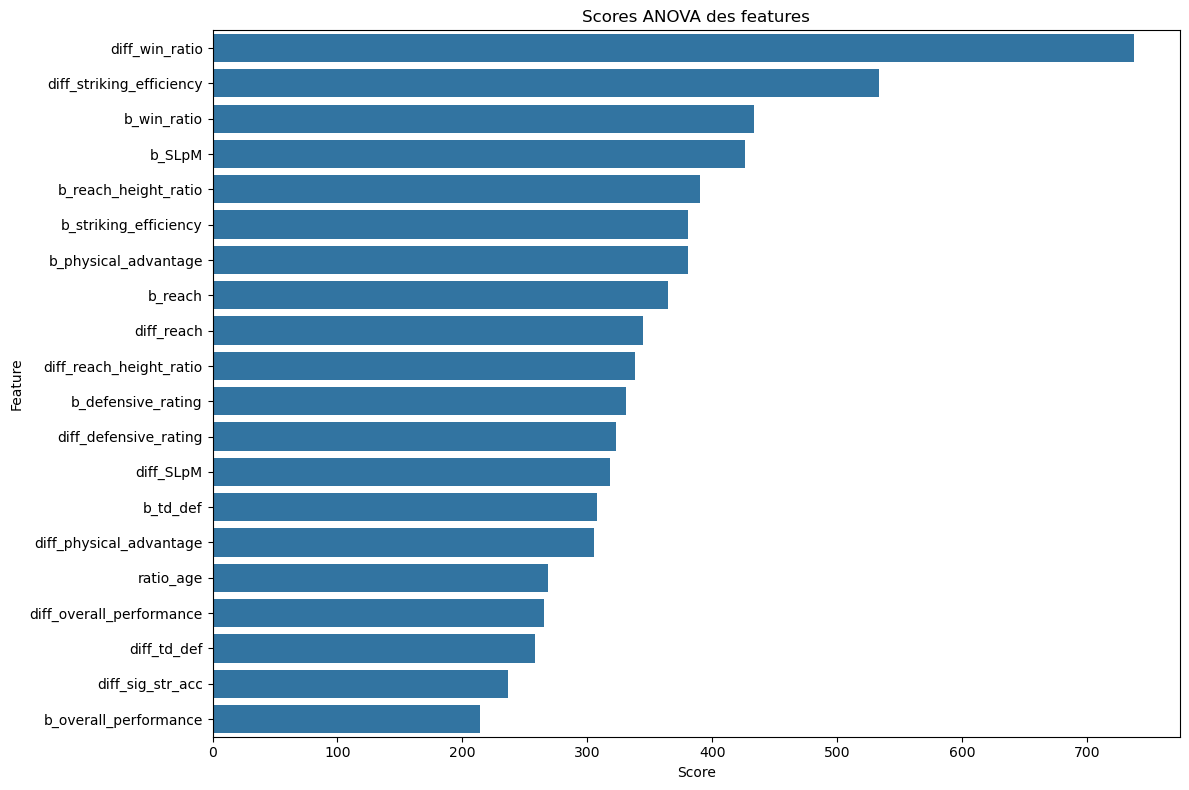


Sélection de variables avec Information Mutuelle...

Top 20 features selon l'Information Mutuelle:
                       Feature  Mutual_Info_Score
66      b_strike_defense_ratio           0.060844
75  b_striking_grappling_ratio           0.059326
61              diff_win_ratio           0.058531
83       b_overall_performance           0.056791
72        b_reach_height_ratio           0.054009
23                   ratio_age           0.050864
25                      b_SLpM           0.050173
60                 b_win_ratio           0.047938
67   diff_strike_defense_ratio           0.047553
86        b_physical_advantage           0.047200
27                  ratio_SLpM           0.046169
77          b_offensive_rating           0.045694
63       b_striking_efficiency           0.044852
3                   ratio_wins           0.044461
80          b_defensive_rating           0.044436
21                       b_age           0.043167
87     diff_physical_advantage           0.041669


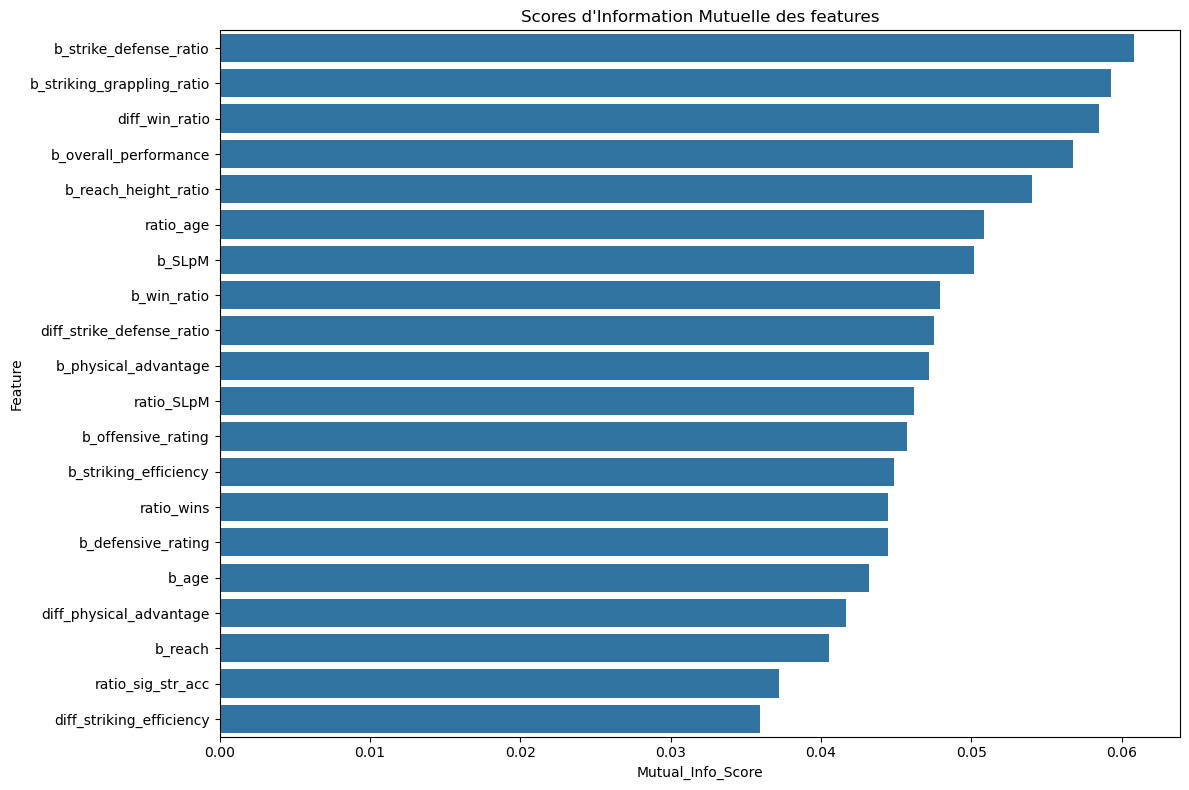


Nombre de features sélectionnées: 21
Features sélectionnées:
['ratio_wins', 'b_reach', 'b_age', 'ratio_age', 'b_SLpM', 'diff_SLpM', 'ratio_SLpM', 'b_win_ratio', 'diff_win_ratio', 'b_striking_efficiency', 'diff_striking_efficiency', 'b_strike_defense_ratio', 'diff_strike_defense_ratio', 'b_reach_height_ratio', 'diff_reach_height_ratio', 'b_defensive_rating', 'diff_defensive_rating', 'b_overall_performance', 'diff_overall_performance', 'b_physical_advantage', 'diff_physical_advantage']

Dimensions réduites - X_train: (6360, 21), X_test: (1591, 21)


In [21]:
# Méthode 1: Utiliser SelectFromModel avec un RandomForest pour la sélection de variables
print("Sélection de variables avec RandomForest...")
select_model = RandomForestClassifier(n_estimators=100, random_state=42)
select_model.fit(X_train, y_train)

# Obtenir l'importance des features
importances = select_model.feature_importances_
feature_names = X.columns

# Créer un DataFrame pour l'importance des features
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Trier par importance décroissante
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Afficher les 20 features les plus importantes
print("\nTop 20 features les plus importantes selon RandomForest:")
print(feature_importance.head(20))

# Visualiser l'importance des features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
plt.title('Importance des features selon RandomForest')
plt.tight_layout()
plt.show()

# Méthode 2: SelectKBest avec f_classif pour une analyse ANOVA
print("\nSélection de variables avec ANOVA (f_classif)...")
selector_f = SelectKBest(f_classif, k=20)
X_train_f = selector_f.fit_transform(X_train, y_train)

# Obtenir les scores et les p-values
scores_f = selector_f.scores_
p_values_f = selector_f.pvalues_

# Créer un DataFrame pour les scores
anova_results = pd.DataFrame({
    'Feature': feature_names,
    'Score': scores_f,
    'p-value': p_values_f
})

# Trier par score décroissant
anova_results = anova_results.sort_values('Score', ascending=False)

# Afficher les 20 features avec les meilleurs scores ANOVA
print("\nTop 20 features selon ANOVA (f_classif):")
print(anova_results.head(20))

# Visualiser les scores ANOVA
plt.figure(figsize=(12, 8))
sns.barplot(x='Score', y='Feature', data=anova_results.head(20))
plt.title('Scores ANOVA des features')
plt.tight_layout()
plt.show()

# Méthode 3: Information mutuelle (mutual information)
print("\nSélection de variables avec Information Mutuelle...")
selector_mi = SelectKBest(mutual_info_classif, k=20)
X_train_mi = selector_mi.fit_transform(X_train, y_train)

# Obtenir les scores
scores_mi = selector_mi.scores_

# Créer un DataFrame pour les scores
mi_results = pd.DataFrame({
    'Feature': feature_names,
    'Mutual_Info_Score': scores_mi
})

# Trier par score décroissant
mi_results = mi_results.sort_values('Mutual_Info_Score', ascending=False)

# Afficher les 20 features avec les meilleurs scores d'information mutuelle
print("\nTop 20 features selon l'Information Mutuelle:")
print(mi_results.head(20))

# Visualiser les scores d'information mutuelle
plt.figure(figsize=(12, 8))
sns.barplot(x='Mutual_Info_Score', y='Feature', data=mi_results.head(20))
plt.title("Scores d'Information Mutuelle des features")
plt.tight_layout()
plt.show()

# Sélection des features les plus pertinentes basée sur les trois méthodes
top_features_rf = set(feature_importance.head(20)['Feature'])
top_features_anova = set(anova_results.head(20)['Feature'])
top_features_mi = set(mi_results.head(20)['Feature'])

# Features qui apparaissent dans au moins deux des trois méthodes de sélection
common_features = []
for feature in feature_names:
    count = 0
    if feature in top_features_rf:
        count += 1
    if feature in top_features_anova:
        count += 1
    if feature in top_features_mi:
        count += 1
    
    if count >= 2:
        common_features.append(feature)

print(f"\nNombre de features sélectionnées: {len(common_features)}")
print("Features sélectionnées:")
print(common_features)

# Filtrer les données pour ne garder que les features sélectionnées
X_filtered = X[common_features]
X_filtered_scaled = scaler.fit_transform(X_filtered)
X_train_filtered, X_test_filtered, y_train, y_test = train_test_split(X_filtered_scaled, y, test_size=0.2, random_state=42)

print(f"\nDimensions réduites - X_train: {X_train_filtered.shape}, X_test: {X_test_filtered.shape}")

In [22]:
# Liste des modèles à tester (avec KNN et MLP ajoutés)
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'MLP': MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
}

# Évaluer chaque modèle avec validation croisée sur les données filtrées
results = {}
print("Évaluation des modèles avec validation croisée (5-fold):")

for name, model in models.items():
    cv_scores = cross_val_score(model, X_train_filtered, y_train, cv=5, scoring='accuracy')
    results[name] = cv_scores.mean()
    print(f"{name}: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

# Identifier le meilleur modèle
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]

print(f"\nMeilleur modèle: {best_model_name} avec une précision de {results[best_model_name]:.4f}")

Évaluation des modèles avec validation croisée (5-fold):
Logistic Regression: 0.7420 (+/- 0.0065)
Random Forest: 0.7392 (+/- 0.0119)
Gradient Boosting: 0.7461 (+/- 0.0113)
SVM: 0.7487 (+/- 0.0087)
XGBoost: 0.7327 (+/- 0.0054)
LightGBM: 0.7417 (+/- 0.0040)
KNN: 0.7009 (+/- 0.0056)
MLP: 0.7215 (+/- 0.0154)

Meilleur modèle: SVM avec une précision de 0.7487


Optimisation de SVM...
Meilleurs paramètres: {'kernel': 'rbf', 'gamma': 'auto', 'C': 1.0}
Meilleur score CV: 0.7469

Précision sur l'ensemble de test avec le modèle optimisé: 0.7593

Rapport de classification:
              precision    recall  f1-score   support

           0       0.75      0.51      0.61       580
           1       0.76      0.90      0.83      1011

    accuracy                           0.76      1591
   macro avg       0.76      0.71      0.72      1591
weighted avg       0.76      0.76      0.75      1591



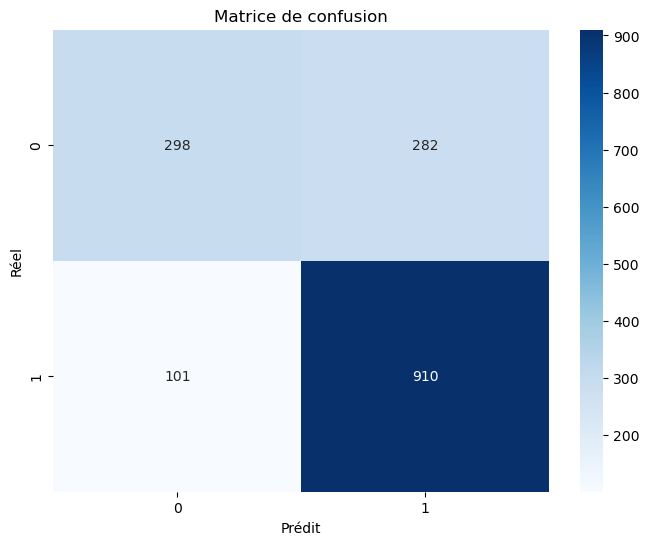

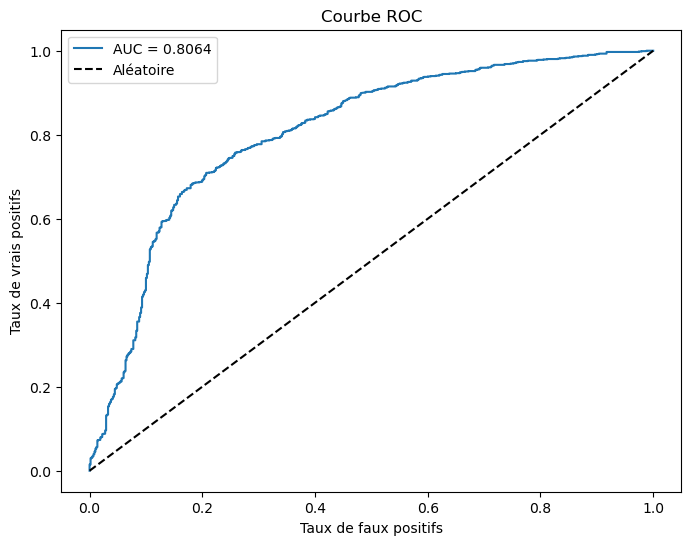

In [23]:
# Optimisation des hyperparamètres pour le meilleur modèle
def optimize_model(model_name, model, X_train, y_train):
    """Optimise rapidement les hyperparamètres du modèle spécifié."""
    print(f"Optimisation de {model_name}...")
    
    if model_name == 'Logistic Regression':
        param_grid = {
            'C': [0.1, 1.0, 10.0],
            'solver': ['liblinear', 'saga']
        }
    elif model_name == 'Random Forest':
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
    elif model_name == 'Gradient Boosting':
        param_grid = {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 10]
        }
    elif model_name == 'SVM':
        param_grid = {
            'C': [0.1, 1.0, 10.0],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']
        }
    elif model_name == 'XGBoost':
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 10],
            'learning_rate': [0.01, 0.1, 0.2]
        }
    elif model_name == 'LightGBM':
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 10],
            'learning_rate': [0.01, 0.1, 0.2]
        }
    elif model_name == 'KNN':
        param_grid = {
            'n_neighbors': [3, 5, 7, 10],
            'weights': ['uniform', 'distance'],
            'p': [1, 2]  # p=1 pour distance Manhattan, p=2 pour distance Euclidienne
        }
    elif model_name == 'MLP':
        param_grid = {
            'hidden_layer_sizes': [(50,), (100,), (50, 50)],
            'activation': ['relu', 'tanh'],
            'alpha': [0.0001, 0.001, 0.01]
        }
    else:
        print(f"Pas de grille d'optimisation définie pour {model_name}")
        return model
    
    # Utiliser RandomizedSearchCV pour une optimisation rapide
    search = RandomizedSearchCV(
        model, param_grid, n_iter=10, cv=3,
        scoring='accuracy', random_state=42, n_jobs=-1
    )
    
    search.fit(X_train, y_train)
    
    print(f"Meilleurs paramètres: {search.best_params_}")
    print(f"Meilleur score CV: {search.best_score_:.4f}")
    
    return search.best_estimator_

# Optimiser le meilleur modèle
optimized_model = optimize_model(best_model_name, best_model, X_train_filtered, y_train)

# Entraîner le modèle optimisé sur l'ensemble complet d'entraînement
optimized_model.fit(X_train_filtered, y_train)

# Évaluer sur l'ensemble de test
y_pred = optimized_model.predict(X_test_filtered)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nPrécision sur l'ensemble de test avec le modèle optimisé: {accuracy:.4f}")

# Afficher le rapport de classification
print("\nRapport de classification:")
print(classification_report(y_test, y_pred))

# Afficher la matrice de confusion
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de confusion')
plt.show()

# Courbe ROC si le modèle peut calculer des probabilités
if hasattr(optimized_model, "predict_proba"):
    y_proba = optimized_model.predict_proba(X_test_filtered)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
    plt.plot([0, 1], [0, 1], 'k--', label='Aléatoire')
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title('Courbe ROC')
    plt.legend()
    plt.show()

In [24]:
def predict_fight(red_fighter, blue_fighter, model, scaler, stats_dict, feature_names):
    """
    Prédit le résultat d'un combat entre deux combattants.
    """
    if red_fighter not in stats_dict or blue_fighter not in stats_dict:
        print(f"Erreur: Un des combattants n'est pas dans la base de données.")
        return None
    
    # Récupérer les statistiques des combattants
    r_stats = stats_dict[red_fighter]
    b_stats = stats_dict[blue_fighter]
    
    # Création d'un DataFrame temporaire pour la prédiction
    temp_df = pd.DataFrame([{
        'r_fighter': red_fighter,
        'b_fighter': blue_fighter,
        'winner': 'Unknown'  # Valeur temporaire qui sera prédite
    }])
    
    # Utiliser notre fonction create_features pour générer les mêmes descripteurs
    features_df = create_features(temp_df, stats_dict)
    
    # Si aucune ligne n'a été générée (problème de données), retourner None
    if len(features_df) == 0:
        print(f"Erreur: Impossible de créer les features pour ces combattants.")
        return None
    
    # Extraire les features sans les noms des combattants et la cible
    features = features_df.drop(['r_fighter', 'b_fighter', 'winner'], axis=1)
    
    # S'assurer que toutes les colonnes nécessaires sont présentes
    for col in feature_names:
        if col not in features.columns:
            features[col] = 0
    
    # Ne garder que les colonnes utilisées par le modèle
    features = features[feature_names]
    
    # Gérer les valeurs manquantes et infinies
    features.replace([np.inf, -np.inf], np.nan, inplace=True)
    features.fillna(0, inplace=True)
    
    # Normaliser les données
    X_scaled = scaler.transform(features)
    
    # Prédire la probabilité de victoire du combattant rouge
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_scaled)[0][1]
    else:
        proba = model.predict(X_scaled)[0]
    
    return proba

# Exemple d'utilisation
def test_prediction():
    # Vous pouvez remplacer par des combattants de votre jeu de données
    red_fighter = "Josh Emmett"
    blue_fighter = "Lerone Murphy"
    
    # Prédire le résultat
    proba = predict_fight(
        red_fighter, 
        blue_fighter, 
        optimized_model, 
        scaler, 
        fighter_stats, 
        common_features
    )
    
    if proba is not None:
        print(f"Probabilité que {red_fighter} (rouge) gagne contre {blue_fighter} (bleu): {proba:.2f}")
        print(f"Probabilité que {blue_fighter} (bleu) gagne contre {red_fighter} (rouge): {1-proba:.2f}")
        
        if proba > 0.5:
            print(f"Prédiction: {red_fighter} (rouge) va gagner!")
        else:
            print(f"Prédiction: {blue_fighter} (bleu) va gagner!")

# Tester la prédiction
test_prediction()

Probabilité que Josh Emmett (rouge) gagne contre Lerone Murphy (bleu): 0.09
Probabilité que Lerone Murphy (bleu) gagne contre Josh Emmett (rouge): 0.91
Prédiction: Lerone Murphy (bleu) va gagner!


In [25]:
def optimal_predict_strategy(fighter1, fighter2, model, scaler, stats_dict, feature_names):
    """
    Utilise la stratégie optimale pour prédire un combat entre deux combattants.
    Détermine quel combattant mettre en rouge/bleu pour maximiser la précision.
    """
    # Vérifier si les deux combattants existent dans notre base de données
    if fighter1 not in stats_dict or fighter2 not in stats_dict:
        print(f"Erreur: Un des combattants n'est pas dans la base de données.")
        return None
    
    # Analyser les configurations possibles
    # 1. Fighter1 en rouge, Fighter2 en bleu
    proba1 = predict_fight(fighter1, fighter2, model, scaler, stats_dict, feature_names)
    
    # 2. Fighter2 en rouge, Fighter1 en bleu
    proba2 = predict_fight(fighter2, fighter1, model, scaler, stats_dict, feature_names)
    
    # Déterminer la configuration optimale
    if proba1 is None or proba2 is None:
        print("Erreur lors de la prédiction.")
        return None
    
    # Si proba1 > 0.5, fighter1 est prédit comme gagnant quand il est en rouge
    # Si proba2 > 0.5, fighter2 est prédit comme gagnant quand il est en rouge
    # Nous voulons la configuration avec la plus grande certitude
    if proba1 > 0.5 and proba1 >= 1-proba2:
        # Fighter1 en rouge avec une prédiction plus certaine
        red_fighter = fighter1
        blue_fighter = fighter2
        win_proba = proba1
    elif proba2 > 0.5 and proba2 >= 1-proba1:
        # Fighter2 en rouge avec une prédiction plus certaine
        red_fighter = fighter2
        blue_fighter = fighter1
        win_proba = proba2
    elif proba1 <= 0.5 and 1-proba1 >= proba2:
        # Fighter2 en bleu avec une prédiction plus certaine
        red_fighter = fighter1
        blue_fighter = fighter2
        win_proba = 1-proba1
        predicted_winner = blue_fighter
    else:
        # Fighter1 en bleu avec une prédiction plus certaine
        red_fighter = fighter2
        blue_fighter = fighter1
        win_proba = 1-proba2
        predicted_winner = blue_fighter
    
    # Déterminer le gagnant prédit
    if win_proba == proba1 or win_proba == proba2:
        predicted_winner = red_fighter
    else:
        predicted_winner = blue_fighter
    
    # Calculer les win_ratios pour contexte
    r_stats = stats_dict[red_fighter]
    b_stats = stats_dict[blue_fighter]
    
    r_wins = get_float_value(r_stats, 'wins', 0)
    r_losses = get_float_value(r_stats, 'losses', 0)
    r_win_ratio = r_wins / (r_wins + r_losses) if (r_wins + r_losses) > 0 else 0
    
    b_wins = get_float_value(b_stats, 'wins', 0)
    b_losses = get_float_value(b_stats, 'losses', 0)
    b_win_ratio = b_wins / (b_wins + b_losses) if (b_wins + b_losses) > 0 else 0
    
    print(f"Configuration optimale:")
    print(f"  Coin rouge: {red_fighter} (win_ratio: {r_win_ratio:.2f})")
    print(f"  Coin bleu: {blue_fighter} (win_ratio: {b_win_ratio:.2f})")
    
    if predicted_winner == red_fighter:
        print(f"Probabilité que {red_fighter} (rouge) gagne: {win_proba:.2f}")
        print(f"Probabilité que {blue_fighter} (bleu) gagne: {1-win_proba:.2f}")
    else:
        print(f"Probabilité que {blue_fighter} (bleu) gagne: {win_proba:.2f}")
        print(f"Probabilité que {red_fighter} (rouge) gagne: {1-win_proba:.2f}")
    
    print(f"Prédiction finale: {predicted_winner} va gagner le combat! (confiance: {win_proba:.2f})")
    
    return predicted_winner, win_proba

# Tester la stratégie optimale
def test_optimal_strategy():
    # Vous pouvez remplacer par des combattants de votre jeu de données
    fighter1 = "Josh Emmett"
    fighter2 = "Lerone Murphy"
    
    # Prédire avec la stratégie optimale
    result = optimal_predict_strategy(
        fighter1, 
        fighter2, 
        optimized_model, 
        scaler, 
        fighter_stats, 
        common_features
    )
    
    return result

# Tester la prédiction avec stratégie optimale
test_optimal_strategy()

Configuration optimale:
  Coin rouge: Josh Emmett (win_ratio: 0.79)
  Coin bleu: Lerone Murphy (win_ratio: 1.00)
Probabilité que Lerone Murphy (bleu) gagne: 0.91
Probabilité que Josh Emmett (rouge) gagne: 0.09
Prédiction finale: Lerone Murphy va gagner le combat! (confiance: 0.91)


('Lerone Murphy', 0.9133889186744252)

In [26]:
import pickle
import joblib
import os

# Créer un dossier pour les modèles s'il n'existe pas
os.makedirs("models", exist_ok=True)

# 1. Sauvegarde avec pickle (méthode standard)
def save_model_pickle(model, scaler, feature_names, filename="models/ufc_prediction_model.pkl"):
    """
    Sauvegarde le modèle, le scaler et les noms des features avec pickle.
    """
    model_data = {
        'model': model,
        'scaler': scaler,
        'feature_names': feature_names
    }
    
    with open(filename, 'wb') as file:
        pickle.dump(model_data, file)
    
    print(f"Modèle sauvegardé avec succès: {filename}")

# 2. Sauvegarde avec joblib (recommandé pour les gros modèles)
def save_model_joblib(model, scaler, feature_names, filename="models/ufc_prediction_model.joblib"):
    """
    Sauvegarde le modèle, le scaler et les noms des features avec joblib.
    """
    model_data = {
        'model': model,
        'scaler': scaler,
        'feature_names': feature_names
    }
    
    joblib.dump(model_data, filename)
    
    print(f"Modèle sauvegardé avec succès: {filename}")

# Sauvegarder le modèle optimisé (utiliser l'une des deux méthodes)
save_model_pickle(optimized_model, scaler, common_features)
save_model_joblib(optimized_model, scaler, common_features)

# Sauvegarder également le dictionnaire de statistiques des combattants
with open("models/fighter_stats.pkl", "wb") as file:
    pickle.dump(fighter_stats, file)

print("Statistiques des combattants sauvegardées avec succès")

Modèle sauvegardé avec succès: models/ufc_prediction_model.pkl
Modèle sauvegardé avec succès: models/ufc_prediction_model.joblib
Statistiques des combattants sauvegardées avec succès
